# 🌲 From Trees to Forests

In the previous notebook, we saw that decision trees can easily overfit if allowed to grow deep. Although they are flexible and interpretable, they are also **unstable**: small changes in data can lead to very different trees.

In this notebook, we introduce **ensemble methods** — techniques that combine multiple models to improve prediction performance and robustness.

We'll focus on:
- 🧃 **Bagging**: Averaging multiple trees (or other ML models) trained on resampled data to reduce variance
- 🌳 **Random Forests**: An extension of bagging that further improves performance by reducing correlation between trees

We'll see how simple modifications to the decision tree setup can lead to **state-of-the-art performance** with no need for gradient descent or deep networks.


## 🌿 Bagging: Bootstrap Aggregating

**Bagging** (short for *Bootstrap Aggregating*) is a powerful ensemble method that improves prediction accuracy by reducing the **variance** of high-variance models like decision trees.

### 🔁 The Idea

Instead of training a single model on the entire dataset, bagging trains **multiple models** on **bootstrapped subsets** of the training data. A *bootstrap sample* is a dataset of the same size as the original, drawn **with replacement**, so some points may repeat and others may be omitted.

Each model is trained independently, and their predictions are then **averaged** (for regression) or **voted** (for classification).

> ### 📦 Bootstrap Sampling
> 
> Let the original dataset be:
> 
> $$
> \mathcal{D} = \{(x_1, y_1), (x_2, y_2), \dots, (x_N, y_N)\}
> $$
> 
> A bootstrap sample $ \mathcal{D}^* $ is constructed by sampling $ N $ times **with replacement** from $ \mathcal{D} $:
> 
> $$
> \mathcal{D}^* = \{(x_{i_1}, y_{i_1}), (x_{i_2}, y_{i_2}), \dots, (x_{i_N}, y_{i_N})\}, \quad i_j \sim \text{Uniform}\{1, \dots, N\}
> $$
> 
>

Each data point has a chance to appear multiple times or not at all in $ \mathcal{D}^* $.  
In fact, the probability that a given point is **not selected at all** is approximately:

$$
\left(1 - \frac{1}{N} \right)^N \approx e^{-1} \approx 0.368
$$

So on average, **36.8% of the original data is left out** of each bootstrap sample.


> ### 🗳️ Bagged Classifier (Voting)
>
> Given $B$ classifiers $f_1, f_2, \dots, f_B$ trained on bootstrap samples $\mathcal{D}_1, \dots, \mathcal{D}_B$, the **bagged classifier** makes predictions by majority vote:
>
> $$
> \hat{f}_{\text{bag}}(x) = \mathrm{mode} \left( \{ f_b(x) \}_{b=1}^B \right)
> $$
> 
> That is, the predicted class $\hat{f}_{\text{bag}}(x)$ is the one most frequently predicted by the individual models.
>
> For regression tasks, bagging uses averaging instead:
> $$
> \hat{f}_{\text{bag}}(x) = \frac{1}{B} \sum_{b=1}^B f_b(x)
> $$
>


### 📉 Variance Reduction

The main goal goal of bagging is to reduce **variance** — the part of generalization error caused by the model's sensitivity to small changes in the training data. In the **regression case**, it is easy to see how bagging achieves this. 

Suppose the variance of a single classifier is 
$$
  \text{Var}[\hat{f}_{b}(x)] = \sigma^2, \quad b=1, \dots, B,
$$
then the variance of the bagged predictor is:


- With independent models:  
  $$
  \text{Var}[\hat{f}_{\text{bag}}(x)] = \frac{\sigma^2}{B}
  $$

- With correlated models (more realistic):  
  $$
  \text{Var}[\hat{f}_{\text{bag}}(x)] = \rho \sigma^2 + \frac{1 - \rho}{B} \sigma^2,
  $$
    where $\rho $ is the average correlation between models

As long as the base models are not fully correlated, bagging will reduce variance and improve generalization.

> For **classification case**, it's a bit harder to write variance formulas. However, bagging still imporves stability and generalization in practice. 

### 🛠️ Implementation of Bagged Classifier

We implement a general-purpose `BaggedClassifier` that ensembles any given base classifier using bagging.

The implementation structure is simple:
- Train multiple copies of the base model, each on a **bootstrapped sample** of the training set.
- During prediction, the individual models vote, and the final prediction is made by **majority vote**.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import tqdm 

# Add the repo root (two levels up from this notebook) to sys.path
sys.path.insert(0, os.path.abspath("../../"))

In [2]:
class BaggedClassifier:
    def __init__(self, base_model_class, n_estimators=10, **model_kwargs):
        """
        Parameters:
        - base_model_class: class of the model to bag (e.g. DecisionTreeClassifier)
        - n_estimators: number of base models
        - model_kwargs: arguments passed to each base model
        """
        self.base_model_class = base_model_class
        self.n_estimators = n_estimators
        self.model_kwargs = model_kwargs
        self.models = []

    def fit(self, X, y):
        self.models = []
        n_samples = len(X)
        for _ in range(self.n_estimators):
            # Bootstrap sampling
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_sample, y_sample = X[indices], y[indices]
            # Create and fit a new model
            model = self.base_model_class(**self.model_kwargs)
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def __call__(self, X):
        all_preds = np.array([model(X) for model in self.models])
        return np.apply_along_axis(self._majority_vote, axis=0, arr=all_preds)

    def _majority_vote(self, predictions):
        """
        Computes the most frequent class label in the predictions list.
        """
        labels, counts = np.unique(predictions, return_counts=True)
        return labels[np.argmax(counts)]

### 🔠 Test on Letter Recognition Dataset

We will test out `BaggedClassifier` on Letter Recognition Dataset using `DecisionTreeClassifier` as a base model.

In [3]:
from courselib.utils.loaders import load_digits
from courselib.utils.splits import train_test_split
from courselib.utils.preprocessing import labels_to_numbers

df = load_digits()

X, Y, X_train, Y_train, X_test, Y_test = train_test_split(df, 0.8, return_numpy=True, class_column_name='letter')
class_names = np.unique(Y)
Y = labels_to_numbers(Y, class_names)
Y_train = labels_to_numbers(Y_train, class_names)
Y_test = labels_to_numbers(Y_test, class_names)

Loading from local `letter-recognition.data`...


#### Train and Evaluate

In [4]:
from courselib.models.tree import DecisionTreeClassifier
from courselib.utils.metrics import accuracy

model = BaggedClassifier(base_model_class=DecisionTreeClassifier, 
                         n_estimators=10, 
                         max_depth=20, 
                         min_samples_split=1)
model.fit(X_train, Y_train)

test_acc = accuracy(model(X_test), Y_test, one_hot_encoded_labels=False)
train_acc = accuracy(model(X_train), Y_train, one_hot_encoded_labels=False)

print(f"✅ Train Accuracy: {train_acc:.4f}")
print(f"🧪 Test Accuracy:  {test_acc:.4f}")


✅ Train Accuracy: 99.3062
🧪 Test Accuracy:  91.8750


#### 📈 Effects of the Ensemble Size

We vary the number of estimators in the bagging ensemble to observe how ensemble size affects performance.  

100%|██████████| 10/10 [12:10<00:00, 73.00s/it] 


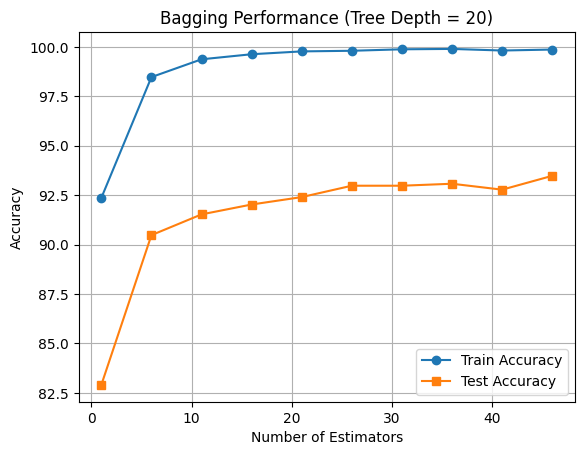

In [5]:
n_estimators_values = range(1, 51, 5)  # Values for number of estimators to evaluate
train_scores = []
test_scores = []

depth = 20   
for n_estimators in tqdm.tqdm(n_estimators_values):
    model = BaggedClassifier(
        base_model_class=DecisionTreeClassifier,
        n_estimators=n_estimators,
        max_depth=depth,
        min_samples_split=1
    )
    model.fit(X_train, Y_train)

    train_acc = accuracy(model(X_train), Y_train, one_hot_encoded_labels=False)
    test_acc = accuracy(model(X_test), Y_test, one_hot_encoded_labels=False)

    train_scores.append(train_acc)
    test_scores.append(test_acc)

# Plotting
plt.plot(n_estimators_values, train_scores, marker='o', label='Train Accuracy')
plt.plot(n_estimators_values, test_scores, marker='s', label='Test Accuracy')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title(f'Bagging Performance (Tree Depth = {depth})')
plt.legend()
plt.grid(True)
plt.show()


We see that ensembling indeed improves performance significantly, especially as we go from a single tree to a small ensemble. 

## 🌳 Random Forest: Decorrelated Bagging

Bagging works well when the base models are high-variance and **somewhat diverse**. However, decision trees trained on bootstrap samples tend to be **highly correlated** because they all focus on the most informative features.

**Random Forests** address this by adding a second source of randomness: at each split, they consider only a **random subset of features**. This reduces correlation $ \rho $, making bagging even more effective.

At each **split node** of each tree:
- Instead of considering **all features**, only a **random subset of features** is considered for the split.
- This prevents trees from always focusing on the most dominant features, encouraging **diverse splits** and reducing the **correlation** between trees.

### 🛠️ Implementation

To implement a random forest, we need to:

1. Train $B$ decision trees, each on a **bootstrap sample** of the training data.
2. While building each tree, modify the split-selection logic to:
   - At each node, choose the **best split only among a random subset of features**.
3. Use **majority vote** across all trees for prediction (classification)

> Step 2 requires a small modification to our `DecisionTreeClassifier`: we need to pass the `max_features` parameter, which restricts how many  features are considered in each split. Then, we choose a random subset of features in `_best_split` method. We incorporate these changes  directly in `courselib.models.tree`.

### ⚙️ Key Parameters

- **Number of trees** ($B$): how many trees to include in the ensemble
- **Max depth**: how deep each tree is allowed to grow
- **Min samples split**: minimum number of samples required to split a node
- **Max features per split** ($m$): how many features are randomly selected at each node  
  Common choice for classification is $m = \sqrt{d}$, where $d$ is the total number of features.

> **Note:** While our implementation of bagging was general and admitted different base classifiers, Random Forest only works for trees as base models.

In [6]:
class RandomForestClassifier:
    def __init__(self, n_estimators=10, max_depth=5, min_samples_split=2, max_features=None):
        """
        Random Forest as a bagged ensemble of decision trees with feature subsampling.

        Parameters:
        - n_estimators: number of trees
        - max_depth: max depth of each tree
        - min_samples_split: min number of samples to split
        - max_features: number of features to consider at each split
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.models = []

    def fit(self, X, y):
        self.models = []
        n_samples = len(X)
        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_sample, y_sample = X[indices], y[indices]
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=self.max_features
            )
            tree.fit(X_sample, y_sample)
            self.models.append(tree)

    def __call__(self, X):
        all_preds = np.array([model(X) for model in self.models])
        return np.apply_along_axis(self._majority_vote, axis=0, arr=all_preds)

    def _majority_vote(self, predictions):
        labels, counts = np.unique(predictions, return_counts=True)
        return labels[np.argmax(counts)]


#### Train and Evaluate

In [ ]:
from courselib.utils.metrics import accuracy

num_features = X_train.shape[1]

model = RandomForestClassifier(n_estimators=10, 
                               max_depth=20, 
                               min_samples_split=1,
                               max_features=int(np.sqrt(num_features)))
model.fit(X_train, Y_train)

test_acc = accuracy(model(X_test), Y_test, one_hot_encoded_labels=False)
train_acc = accuracy(model(X_train), Y_train, one_hot_encoded_labels=False)

print(f"✅ Train Accuracy: {train_acc:.4f}")
print(f"🧪 Test Accuracy:  {test_acc:.4f}")


✅ Train Accuracy: 99.7125
🧪 Test Accuracy:  92.9250


#### 📉 Variance Reduction

To demonstrate variance reduction, we repeat the analysis of prediction disagreement across models trained on slightly different data.

Specifically, we train **10 Random Forest classifiers**, each on a different random subset of the training set. Then, we evaluate their predictions on a **shared test set** and compute, for each test sample, how often the classifiers disagree.

Compared to single decision trees, we expect Random Forests to produce more stable predictions — i.e., lower disagreement across models.


100%|██████████| 10/10 [11:24<00:00, 68.43s/it]


Average disagreement across all samples: 0.2383


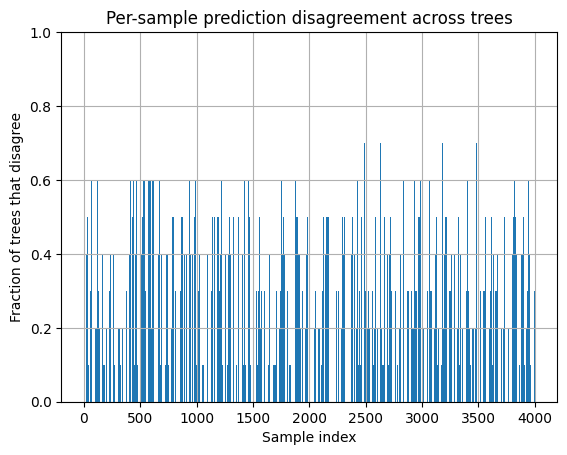

In [9]:
depth = 15
predictions = []

n_samples = X_train.shape[0]
n_test_sampes = X_test.shape[0]

for _ in tqdm.tqdm(range(10)):

    # Randomly sample 80% of the training data for each run
    indices = np.random.choice(n_samples, size=(n_samples)//5*4)
    X_sample, Y_sample = X_train[indices], X_train[indices]

    model = RandomForestClassifier(n_estimators=20, 
                                   max_depth=depth, 
                                   min_samples_split=1,
                                   max_features=int(np.sqrt(num_features)))
    model.fit(X_sample, Y_sample)

    # Predict on the test set (not used in training in any run)
    preds = model(X_test)
    predictions.append(preds)

predictions = np.array(predictions)  # shape: (n_runs, n_samples)

def majority_vote(preds):
    #Return the most common prediction
    return np.bincount(preds).argmax()

# Compute majority prediction per sample
majority_preds = np.apply_along_axis(majority_vote, axis=0, arr=predictions)

# Compute fraction of disagreeing trees for each sample
disagreement = np.mean(predictions != majority_preds, axis=0)  # shape: (n_samples,)

plt.bar(range(n_test_sampes), disagreement)
plt.xlabel("Sample index")
plt.ylabel("Fraction of trees that disagree")
plt.title("Per-sample prediction disagreement across trees")
plt.ylim(0, 1)
plt.grid(True)

print(f"Average disagreement across all samples: {np.mean(disagreement):.4f}")

Indeed, while some disagreement remains, ensembling 20 trees using a Random Forest reduces the **average disagreement** across models to around **20%**, compared to **40%** for individual decision trees.

#### Joint Effects of Tree Depth and Ensemble Size

We investigate how **tree depth** and **ensemble size** jointly affect the performance of a Random Forest.

7it [04:35, 39.32s/it]


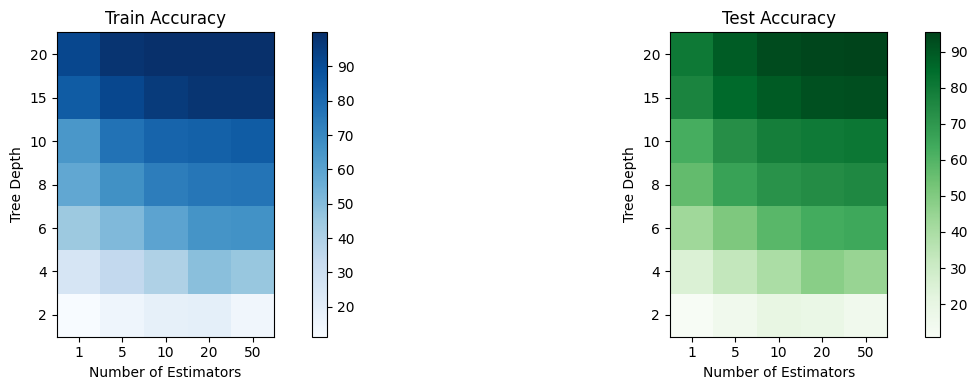

In [10]:
depth_values = [2, 4, 6, 8, 10, 15, 20]
n_estimators_values = [1, 5, 10, 20, 50]

train_scores = np.zeros((len(depth_values), len(n_estimators_values)))
test_scores = np.zeros((len(depth_values), len(n_estimators_values)))

for i, depth in tqdm.tqdm(enumerate(depth_values)):
    for j, n_estimators in enumerate(n_estimators_values):
        model = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=depth,
                min_samples_split=1,
                max_features=int(np.sqrt(num_features)))
        model.fit(X_train, Y_train)

        train_acc = accuracy(model(X_train), Y_train, one_hot_encoded_labels=False)
        test_acc = accuracy(model(X_test), Y_test, one_hot_encoded_labels=False)

        train_scores[i, j] = train_acc
        test_scores[i, j] = test_acc

# Plot as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

im1 = axes[0].imshow(train_scores, cmap="Blues", origin="lower")
axes[0].set_title("Train Accuracy")
axes[0].set_xticks(range(len(n_estimators_values)))
axes[0].set_xticklabels(n_estimators_values)
axes[0].set_yticks(range(len(depth_values)))
axes[0].set_yticklabels(depth_values)
axes[0].set_xlabel("Number of Estimators")
axes[0].set_ylabel("Tree Depth")
fig.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(test_scores, cmap="Greens", origin="lower")
axes[1].set_title("Test Accuracy")
axes[1].set_xticks(range(len(n_estimators_values)))
axes[1].set_xticklabels(n_estimators_values)
axes[1].set_yticks(range(len(depth_values)))
axes[1].set_yticklabels(depth_values)
axes[1].set_xlabel("Number of Estimators")
axes[1].set_ylabel("Tree Depth")
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()


We see that ensembling consistently improves accuracy across a wide range of tree depths. Even shallow trees benefit from random forests, but **deeper trees** tend to perform better overall when combined with ensembling. 

With sufficient depth and ensemble size, we can achieve **near-state-of-the-art** results for letter recognition using random forest!